Experiment to use lora to make a lying model. Here we think of Lora as a probe, as it acts in a very similar way - modifying the residual stream.

Then the hope is it will assist at lie detecting and generalize to unseen dataset

- https://github.dev/JD-P/minihf/blob/b54075c34ef88d9550e37fdf709e78e5a68787c4/lora_tune.py
- https://github.com/jonkrohn/NLP-with-LLMs

In [1]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm.auto import tqdm

plt.style.use("ggplot")

from typing import Optional, List, Dict, Union
from jaxtyping import Float
from torch import Tensor

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch import Tensor
from torch import optim
from torch.utils.data import random_split, DataLoader, TensorDataset

from pathlib import Path
from einops import rearrange

import transformers
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    BitsAndBytesConfig,
    AutoConfig,
)
from peft import (
    get_peft_config,
    get_peft_model,
    LoraConfig,
    TaskType,
    LoftQConfig,
    IA3Config,
)

import datasets
from datasets import Dataset

from loguru import logger

logger.add(os.sys.stderr, format="{time} {level} {message}", level="INFO")


# # quiet please
torch.set_float32_matmul_precision("medium")
import warnings

warnings.filterwarnings("ignore", ".*does not have many workers.*")
# warnings.filterwarnings(
#     "ignore", ".*sampler has shuffling enabled, it is strongly recommended that.*"
# )
# warnings.filterwarnings("ignore", ".*has been removed as a dependency of.*")


In [2]:
# load my code
%load_ext autoreload
%autoreload 2

import lightning.pytorch as pl
from src.datasets.dm import DeceptionDataModule
from src.models.pl_lora_ft import AtapterFinetuner

from src.config import ExtractConfig
from src.prompts.prompt_loading import load_preproc_dataset, load_preproc_datasets
from src.models.load import load_model
from src.helpers.torch_helpers import clear_mem
from src.models.phi.model_phi import PhiForCausalLMWHS


## Parameters


In [3]:
# params
max_epochs = 5
device = "cuda:0"

cfg = ExtractConfig(
    max_examples=(1000, 1000),
    # model="wassname/phi-1_5-w_hidden_states",
    # batch_size=3,
    # model="wassname/phi-2-w_hidden_states",
    model="microsoft/phi-2",
    # model="microsoft/phi-1_5",
    # model="Walmart-the-bag/phi-2-uncensored",
    batch_size=1,
    prompt_format="phi",
)


## Load model

In [4]:
model, tokenizer = load_model(
    cfg.model,
    device=device,
    model_class=PhiForCausalLMWHS, # ti add hidden states
)
model


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

PhiForCausalLMWHS(
  (transformer): PhiModel(
    (embd): Embedding(
      (wte): Embedding(51200, 2560)
      (drop): Dropout(p=0.0, inplace=False)
    )
    (h): ModuleList(
      (0-31): 32 x ParallelBlock(
        (ln): LayerNorm((2560,), eps=1e-05, elementwise_affine=True)
        (resid_dropout): Dropout(p=0.1, inplace=False)
        (mixer): MHA(
          (rotary_emb): RotaryEmbedding()
          (Wqkv): Linear4bit(in_features=2560, out_features=7680, bias=True)
          (out_proj): Linear4bit(in_features=2560, out_features=2560, bias=True)
          (inner_attn): SelfAttention(
            (drop): Dropout(p=0.0, inplace=False)
          )
          (inner_cross_attn): CrossAttention(
            (drop): Dropout(p=0.0, inplace=False)
          )
        )
        (mlp): MLP(
          (fc1): Linear4bit(in_features=2560, out_features=10240, bias=True)
          (fc2): Linear4bit(in_features=10240, out_features=2560, bias=True)
          (act): NewGELUActivation()
        )
    

In [5]:
# for normal seetings see https://github.com/huggingface/peft/blob/cf04d0353f0343cbf66627228c4495f51669af34/src/peft/utils/constants.py#L81
# and https://github.com/huggingface/peft/blob/cf04d0353f0343cbf66627228c4495f51669af34/src/peft/utils/constants.py#L102
# "llama": ["k_proj", "v_proj", "down_proj"],
# "gptj": ["q_proj", "v_proj", "fc_out"],
# "falcon": ["query_key_value", "dense_4h_to_h"],

# for activation gathering
peft_config = IA3Config(
    task_type=TaskType.SEQ_CLS, target_modules=[ "fc1", "Wqkv",], 
        feedforward_modules=[]
)
# peft_config = IA3Config(
#     task_type=TaskType.SEQ_CLS, target_modules=[ "fc1", "fc2", "Wqkv","out_proj"], 
#         feedforward_modules=["fc2","out_proj", "fc1"]
# )

# peft_config = IA3Config(
#     task_type=TaskType.SEQ_CLS, target_modules=[  "fc2", "out_proj"], 
#         feedforward_modules=[]
# )
model = get_peft_model(model, peft_config)
model.print_trainable_parameters()


trainable params: 163,840 || all params: 2,779,847,680 || trainable%: 0.005893848111850503


In [6]:
model


PeftModelForSequenceClassification(
  (base_model): IA3Model(
    (model): PhiForCausalLMWHS(
      (transformer): PhiModel(
        (embd): Embedding(
          (wte): Embedding(51200, 2560)
          (drop): Dropout(p=0.0, inplace=False)
        )
        (h): ModuleList(
          (0-31): 32 x ParallelBlock(
            (ln): LayerNorm((2560,), eps=1e-05, elementwise_affine=True)
            (resid_dropout): Dropout(p=0.1, inplace=False)
            (mixer): MHA(
              (rotary_emb): RotaryEmbedding()
              (Wqkv): Linear4bit(in_features=2560, out_features=7680, bias=True)
              (out_proj): ia3.Linear4bit(
                (base_layer): Linear4bit(in_features=2560, out_features=2560, bias=True)
                (ia3_l): ParameterDict(  (default): Parameter containing: [torch.cuda.FloatTensor of size 2560x1 (cuda:0)])
              )
              (inner_attn): SelfAttention(
                (drop): Dropout(p=0.0, inplace=False)
              )
              (inn

## Load datasets

In [7]:
assert len(set(cfg.datasets).intersection(cfg.datasets_ood))==0, "datasets overlap"


In [8]:
N = sum(cfg.max_examples)
ds_tokens = load_preproc_datasets(
    cfg.datasets,
    tokenizer,
    N=N,
    seed=cfg.seed,
    num_shots=cfg.num_shots,
    max_length=cfg.max_length,
    prompt_format=cfg.prompt_format,
)
ds_tokens


2023-12-29 12:09:22.341 | INFO     | src.prompts.prompt_loading:load_preproc_dataset:359 - setting tokenizer chat template to phi
2023-12-29T12:09:22.341164+0800 INFO setting tokenizer chat template to phi
2023-12-29 12:09:22.408 | INFO     | src.prompts.prompt_loading:load_preproc_dataset:390 - median token length: 398.0 for amazon_polarity. max_length=776
2023-12-29T12:09:22.408760+0800 INFO median token length: 398.0 for amazon_polarity. max_length=776
2023-12-29 12:09:22.410 | INFO     | src.prompts.prompt_loading:load_preproc_dataset:394 - truncation rate: 0.00% on amazon_polarity
2023-12-29T12:09:22.410068+0800 INFO truncation rate: 0.00% on amazon_polarity
/media/wassname/SGIronWolf/projects5/elk/sgd_probes_are_lie_detectors/.venv/lib/python3.11/site-packages/datasets/table.py:1395: FutureWarning: promote has been superseded by mode='default'.
  block_group = [InMemoryTable(cls._concat_blocks(list(block_group), axis=axis))]
/media/wassname/SGIronWolf/projects5/elk/sgd_probes_are

Dataset({
    features: ['ds_string', 'example_i', 'answer', 'messages', 'answer_choices', 'template_name', 'label_true', 'label_instructed', 'instructed_to_lie', 'sys_instr_name', 'question', 'input_ids', 'attention_mask', 'truncated', 'length', 'prompt_truncated', 'choice_ids'],
    num_rows: 2005
})

In [9]:
ds_tokens2 = load_preproc_datasets(
    cfg.datasets_ood,
    tokenizer,
    N=N // 2,
    seed=cfg.seed,
    num_shots=cfg.num_shots,
    max_length=cfg.max_length,
    prompt_format=cfg.prompt_format,
)
ds_tokens2


prompt_truncated:   0%|          | 0/1004 [00:00<?, ? examples/s]

choice_ids:   0%|          | 0/1004 [00:00<?, ? examples/s]

2023-12-29 12:09:25.422 | INFO     | src.prompts.prompt_loading:load_preproc_dataset:390 - median token length: 484.0 for super_glue:boolq. max_length=776
2023-12-29T12:09:25.422536+0800 INFO median token length: 484.0 for super_glue:boolq. max_length=776
2023-12-29 12:09:25.423 | INFO     | src.prompts.prompt_loading:load_preproc_dataset:394 - truncation rate: 2.49% on super_glue:boolq
2023-12-29T12:09:25.423632+0800 INFO truncation rate: 2.49% on super_glue:boolq


Filter:   0%|          | 0/1004 [00:00<?, ? examples/s]

/media/wassname/SGIronWolf/projects5/elk/sgd_probes_are_lie_detectors/.venv/lib/python3.11/site-packages/datasets/table.py:1395: FutureWarning: promote has been superseded by mode='default'.
  block_group = [InMemoryTable(cls._concat_blocks(list(block_group), axis=axis))]
/media/wassname/SGIronWolf/projects5/elk/sgd_probes_are_lie_detectors/.venv/lib/python3.11/site-packages/datasets/table.py:1421: FutureWarning: promote has been superseded by mode='default'.
  table = cls._concat_blocks(blocks, axis=0)


Filter:   0%|          | 0/979 [00:00<?, ? examples/s]

2023-12-29 12:09:26.217 | INFO     | src.prompts.prompt_loading:load_preproc_dataset:403 - num_rows (after filtering out truncated rows) 1004=>979
2023-12-29T12:09:26.217386+0800 INFO num_rows (after filtering out truncated rows) 1004=>979


format_prompt:   0%|          | 0/712 [00:00<?, ? examples/s]

tokenize:   0%|          | 0/712 [00:00<?, ? examples/s]

truncated:   0%|          | 0/712 [00:00<?, ? examples/s]

truncated:   0%|          | 0/712 [00:00<?, ? examples/s]

prompt_truncated:   0%|          | 0/712 [00:00<?, ? examples/s]

choice_ids:   0%|          | 0/712 [00:00<?, ? examples/s]

2023-12-29 12:09:28.593 | INFO     | src.prompts.prompt_loading:load_preproc_dataset:390 - median token length: 167.5 for super_glue:axg. max_length=776
2023-12-29T12:09:28.593220+0800 INFO median token length: 167.5 for super_glue:axg. max_length=776
2023-12-29 12:09:28.594 | INFO     | src.prompts.prompt_loading:load_preproc_dataset:394 - truncation rate: 0.00% on super_glue:axg
2023-12-29T12:09:28.594110+0800 INFO truncation rate: 0.00% on super_glue:axg


Filter:   0%|          | 0/712 [00:00<?, ? examples/s]

/media/wassname/SGIronWolf/projects5/elk/sgd_probes_are_lie_detectors/.venv/lib/python3.11/site-packages/datasets/table.py:1395: FutureWarning: promote has been superseded by mode='default'.
  block_group = [InMemoryTable(cls._concat_blocks(list(block_group), axis=axis))]
/media/wassname/SGIronWolf/projects5/elk/sgd_probes_are_lie_detectors/.venv/lib/python3.11/site-packages/datasets/table.py:1421: FutureWarning: promote has been superseded by mode='default'.
  table = cls._concat_blocks(blocks, axis=0)


Filter:   0%|          | 0/712 [00:00<?, ? examples/s]

2023-12-29 12:09:29.177 | INFO     | src.prompts.prompt_loading:load_preproc_dataset:403 - num_rows (after filtering out truncated rows) 712=>712
2023-12-29T12:09:29.177604+0800 INFO num_rows (after filtering out truncated rows) 712=>712
2023-12-29 12:09:29.242 | INFO     | src.prompts.prompt_loading:load_preproc_dataset:390 - median token length: 776.0 for imdb. max_length=776
2023-12-29T12:09:29.242506+0800 INFO median token length: 776.0 for imdb. max_length=776
2023-12-29 12:09:29.243 | INFO     | src.prompts.prompt_loading:load_preproc_dataset:394 - truncation rate: 63.35% on imdb
2023-12-29T12:09:29.243781+0800 INFO truncation rate: 63.35% on imdb
/media/wassname/SGIronWolf/projects5/elk/sgd_probes_are_lie_detectors/.venv/lib/python3.11/site-packages/datasets/table.py:1395: FutureWarning: promote has been superseded by mode='default'.
  block_group = [InMemoryTable(cls._concat_blocks(list(block_group), axis=axis))]
/media/wassname/SGIronWolf/projects5/elk/sgd_probes_are_lie_detec

Dataset({
    features: ['ds_string', 'example_i', 'answer', 'messages', 'answer_choices', 'template_name', 'label_true', 'label_instructed', 'instructed_to_lie', 'sys_instr_name', 'question', 'input_ids', 'attention_mask', 'truncated', 'length', 'prompt_truncated', 'choice_ids'],
    num_rows: 1002
})

## custom models

In [10]:
from src.models.pl_lora_ft import AtapterFinetuner
from src.helpers.scores import select

class AtapterFinetunerLie(AtapterFinetuner):
    def get_loss(self, batch, out, out_a):
        """
        simply train it to lie
        """

        log_probs_a = torch.log_softmax(out_a["logits"][:, -1,], -1,)

        # batch['instructed_to_lie']
        lie_label = ~batch['label_true']
        choice_ids1 = select(batch["choice_ids"][:, :, 0], lie_label.long())
        choice_ids2 = select(batch["choice_ids"][:, :, 1], lie_label.long())
        loss1 = F.nll_loss(log_probs_a, target=choice_ids1)
        loss2 = F.nll_loss(log_probs_a, target=choice_ids2)
        loss = (loss1 + loss2) / 2

        return loss, None, None


In [11]:
from src.models.pl_lora_ft import AtapterFinetuner
from src.helpers.scores import select


class AtapterFinetunerToldToLie(AtapterFinetuner):
    def get_loss(self, batch, out, out_a):
        """
        train it to lie when instructed
        """

        end_logits = out_a["logits"][
            :,
            -1,
        ]
        log_probs_a = torch.log_softmax(end_logits, -1)

        lie_label = batch["label_true"] ^ batch["instructed_to_lie"]
        choice_ids1 = select(batch["choice_ids"][:, :, 0], lie_label.long())
        choice_ids2 = select(batch["choice_ids"][:, :, 1], lie_label.long())
        loss1 = F.nll_loss(log_probs_a, target=choice_ids1)
        loss2 = F.nll_loss(log_probs_a, target=choice_ids2)
        loss = (loss1 + loss2) / 2

        return loss, None, None


In [12]:
from src.models.pl_lora_ft import AtapterFinetuner
from src.helpers.scores import select


class AtapterFinetunerTruth(AtapterFinetuner):
    def get_loss(self, batch, out, out_a):
        """
        train it to lie when instructed
        """

        end_logits = out_a["logits"][
            :,
            -1,
        ]
        log_probs_a = torch.log_softmax(end_logits, -1)

        lie_label = batch["label_true"] #^ batch["instructed_to_lie"]
        choice_ids1 = select(batch["choice_ids"][:, :, 0], lie_label.long())
        choice_ids2 = select(batch["choice_ids"][:, :, 1], lie_label.long())
        loss1 = F.nll_loss(log_probs_a, target=choice_ids1)
        loss2 = F.nll_loss(log_probs_a, target=choice_ids2)
        loss = (loss1 + loss2) / 2

        return loss, None, None


In [13]:
model_cls = AtapterFinetunerToldToLie


## Train

In [14]:
dm = DeceptionDataModule(ds_tokens, batch_size=cfg.batch_size)
dl_train = dm.train_dataloader()
dl_val = dm.val_dataloader()
len(dl_train), len(dl_val)


(1002, 501)

In [15]:
b = next(iter(dl_train))
print(b.keys(), b["input_ids"].shape)
c_in = b["input_ids"].shape[1]
c_in


dict_keys(['ds_string', 'example_i', 'answer', 'messages', 'answer_choices', 'template_name', 'label_true', 'label_instructed', 'instructed_to_lie', 'sys_instr_name', 'question', 'input_ids', 'attention_mask', 'truncated', 'length', 'prompt_truncated', 'choice_ids']) torch.Size([1, 776])


776

In [16]:
net = model_cls(
    model, tokenizer, lr=5e-3, weight_decay=1e-5, total_steps=len(dl_train) * max_epochs
)

print(c_in)


776


In [17]:
# # debug
# # net.half()
# with torch.no_grad():
#     o = net.training_step(b, None)
# o


In [18]:
# # debug
# with torch.no_grad():
#     o = net.predict_step(b, None)
# o.keys()


In [19]:
# we want to init lightning early, so it inits accelerate
trainer = pl.Trainer(
    precision='16-mixed',

    gradient_clip_val=20,
    devices="1",
    accelerator="gpu",
    accumulate_grad_batches=8,
    max_epochs=max_epochs,
    log_every_n_steps=1,
    # enable_model_summary=False,
)


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/media/wassname/SGIronWolf/projects5/elk/sgd_probes_are_lie_detectors/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:67: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


In [20]:
trainer.fit(model=net, train_dataloaders=dl_train, val_dataloaders=dl_val);


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type                               | Params
-------------------------------------------------------------
0 | model | PeftModelForSequenceClassification | 1.5 B 
-------------------------------------------------------------
163 K     Trainable params
1.5 B     Non-trainable params
1.5 B     Total params
6,086.226 Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


In [21]:
checkpoint_path = Path(trainer.log_dir) / "checkpoint_last"
model.save_pretrained(checkpoint_path)
checkpoint_path


PosixPath('/media/wassname/SGIronWolf/projects5/elk/sgd_probes_are_lie_detectors/notebooks/lightning_logs/version_225/checkpoint_last')

In [22]:
# save config
f = Path(trainer.log_dir) / 'config.yaml'
cfg.save_yaml(f)
f


PosixPath('/media/wassname/SGIronWolf/projects5/elk/sgd_probes_are_lie_detectors/notebooks/lightning_logs/version_225/config.yaml')

## Hist

,train/loss_step,step,val/loss_step
0,4.775288,0,NaN
1,4.879947,1,NaN
2,4.341791,2,NaN
3,5.367697,3,NaN
4,4.873761,4,NaN
...,...,...,...
3140,NaN,2502,4.664123
3141,NaN,2503,4.975610
3142,NaN,2504,8.554306
3143,NaN,629,NaN


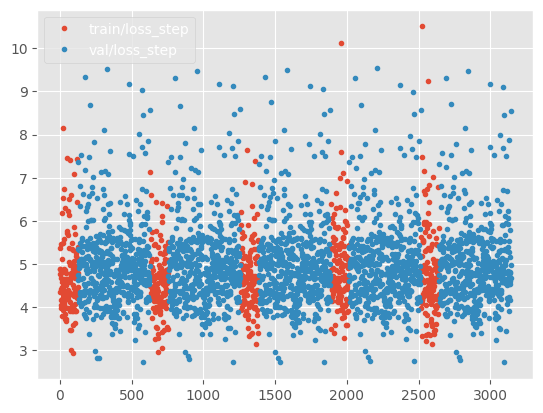

In [23]:
from src.helpers.lightning import read_metrics_csv

df_histe, df_hist = read_metrics_csv(trainer.logger.experiment.metrics_file_path)
df_hist[["train/loss_step", "val/loss_step"]].plot(style=".")
df_hist


<Axes: xlabel='epoch'>

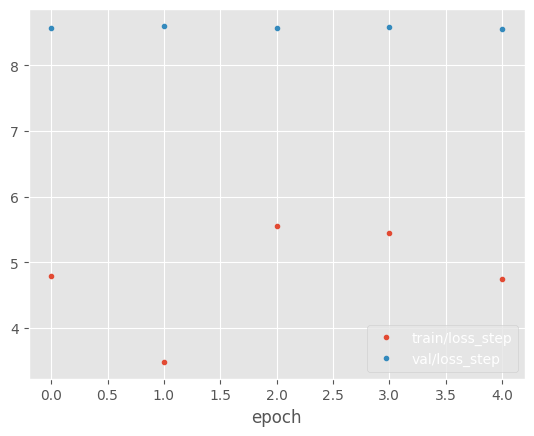

In [24]:
df_histe[["train/loss_step", "val/loss_step"]].plot(style=".")


## Generate

This acts a QC to check of the trained adapter is still coherent while giving the opposite answer


In [25]:
from src.eval.gen import gen


In [26]:

# We need to reload it from checkpoint, since lightning seems to bug it after running
model, tokenizer = model, tokenizer = load_model(
    cfg.model,
    device=device,
    adaptor_path=checkpoint_path,
    dtype=torch.float16,  # bfloat can't be pickled
    model_class=PhiForCausalLMWHS,
    bnb=False,
)
clear_mem()


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [27]:
model.eval()
model.half()
;


''

In [28]:
# Chose a row where we will see the difference

from src.eval.ds import ds2df
df_tokens = ds2df(ds_tokens).reset_index()
mask = (
    (df_tokens['instructed_to_lie']==True) &
    (df_tokens['label_true']==False)
)
bis = df_tokens[mask].index


# # mask = (
# #     (ds_tokens['instructed_to_lie']==True) &
# #     (ds_tokens['label_true']==False)
# # ).float()
bi = int(np.random.choice(bis))
bi
# # TODO doesn't work if the model gets it wrong
inputs = ds_tokens.with_format("torch")[bi]
df_tokens.iloc[bi]




index                                                             1939
ds_string                                                         hans
example_i                                                          286
answer                                                              No
template_name                                          does this imply
label_true                                                       False
label_instructed                                                  True
instructed_to_lie                                                 True
sys_instr_name                                                 default
question             \n\nSystem:\nBelow is an instruction that desc...
truncated                                                        False
length                                                             161
prompt_truncated     <|endoftext|><|endoftext|><|endoftext|><|endof...
Name: 1939, dtype: object

In [29]:
with model.disable_adapter():
    gen(model, inputs, tokenizer)

gen(model, inputs, tokenizer)


/media/wassname/SGIronWolf/projects5/elk/sgd_probes_are_lie_detectors/.venv/lib/python3.11/site-packages/transformers/generation/utils.py:1473: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(


# Test

In [30]:
from src.eval.labels import ds2label_model_obey, ds2label_model_truth


In [31]:
TEST_BATCH_MULT = 3


In [32]:
dm2 = DeceptionDataModule(ds_tokens2, batch_size=cfg.batch_size * TEST_BATCH_MULT)
dl_train2 = dm2.train_dataloader()
dl_train2.shuffle = False

dl_val2 = dm2.val_dataloader()
dl_test2 = dm2.test_dataloader()

dl_valtest2 = DataLoader(
    torch.utils.data.ConcatDataset([dm.datasets["val"], dm.datasets["test"]]),
    batch_size=cfg.batch_size * TEST_BATCH_MULT,
)
len(dl_valtest2.dataset)


1003

In [33]:
dl_OOD = DataLoader(
    ds_tokens2, batch_size=cfg.batch_size * TEST_BATCH_MULT, drop_last=False, shuffle=False
)
len(dl_OOD.dataset)


1002

In [34]:
model, tokenizer = model, tokenizer = load_model(
    cfg.model,
    device=device,
    adaptor_path=checkpoint_path,
    dtype=torch.float16,  # bfloat can't be pickled
    model_class=PhiForCausalLMWHS,
)
net = model_cls(model, tokenizer)
clear_mem()


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [35]:
from src.helpers.lightning import rename_pl_test_results

rs1 = trainer.test(
    net,
    dataloaders=[
        dl_train2,
        dl_val2,
        dl_test2,
        dl_OOD,
    ],
    verbose=False
)
rs = rename_pl_test_results(rs1, ["train", "val", "test", "OOD"])
df_testing = pd.DataFrame(rs)
df_testing


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/media/wassname/SGIronWolf/projects5/elk/sgd_probes_are_lie_detectors/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:492: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.


Testing: |          | 0/? [00:00<?, ?it/s]

,train,val,test,OOD
loss_epoch,5.428176,5.406906,5.433695,5.424201
n,501.000000,250.000000,251.000000,1002.000000


# Predict

Here we want to see if we can do a probe on the hidden states to see if it's lying...


### Collect

- see how acc each was for instructions vs truth
- see how a linear probe trained on the diff can do for truth, vs baseline

In [36]:
model, tokenizer = model, tokenizer = load_model(
    cfg.model,
    device=device,
    adaptor_path=checkpoint_path,
    dtype=torch.float16,  # bfloat can't be pickled
    model_class=PhiForCausalLMWHS,
    bnb=False,
)
clear_mem()


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [37]:
from src.eval.collect import manual_collect2
from src.eval.ds import filter_ds_to_known
from src.eval.labels import LABEL_MAPPING
from src.eval.ds import qc_ds, ds2df, qc_dsdf
from src.helpers.torch_helpers import batch_to_device


In [38]:
# # for single process DEBUGING
# from src.eval.collect import generate_batches
# o = next(iter(generate_batches(dl_OOD, model)))


In [39]:
dataset_dir=Path(trainer.log_dir)/'hidden_states'
ds_out_OOD, f = manual_collect2(dl_OOD, model, dataset_name="OOD", dataset_dir=dataset_dir)
ds_out_valtest, f = manual_collect2(dl_valtest2, model, dataset_name="valtest", dataset_dir=dataset_dir)


2023-12-29 13:41:47.747 | INFO     | src.eval.collect:manual_collect2:57 - creating dataset /media/wassname/SGIronWolf/projects5/elk/sgd_probes_are_lie_detectors/notebooks/lightning_logs/version_225/hidden_states/.ds/ds_OOD_f7dad3cf8d21e944
2023-12-29T13:41:47.747387+0800 INFO creating dataset /media/wassname/SGIronWolf/projects5/elk/sgd_probes_are_lie_detectors/notebooks/lightning_logs/version_225/hidden_states/.ds/ds_OOD_f7dad3cf8d21e944


collecting hidden states:   0%|          | 0/334 [00:00<?, ?it/s]

2023-12-29 13:55:05.025 | INFO     | src.eval.collect:manual_collect2:57 - creating dataset /media/wassname/SGIronWolf/projects5/elk/sgd_probes_are_lie_detectors/notebooks/lightning_logs/version_225/hidden_states/.ds/ds_valtest_b1f1b6ad14b2be5a
2023-12-29T13:55:05.025836+0800 INFO creating dataset /media/wassname/SGIronWolf/projects5/elk/sgd_probes_are_lie_detectors/notebooks/lightning_logs/version_225/hidden_states/.ds/ds_valtest_b1f1b6ad14b2be5a


collecting hidden states:   0%|          | 0/335 [00:00<?, ?it/s]

#### QC ds

In [40]:
def make_dfres2_pretty(styler):
    styler.set_caption("Dataset metrics")
    styler.background_gradient(axis=1, vmin=0, vmax=1, cmap="RdYlGn", 
                               subset=['auroc', 'lie_auroc', 'known_lie_auroc', 'choice_cov']
                               )
    styler.background_gradient(axis=1, vmin=0, vmax=0.5, cmap="RdYlGn", 
                               subset=['balance']
                               )
    return styler


In [41]:
df1 = ds2df(ds_out_valtest)
df_b = df1.rename(columns=lambda x: x.replace("_base", "")).copy()
res_b = qc_dsdf(df_b)
df_a = df1.rename(columns=lambda x: x.replace("_adapt", "")).copy()
res_a = qc_dsdf(df_a)
df_res_ab = pd.DataFrame([res_b, res_a], index=["base", "adapter"])
print("🥉 secondary metric: dataset quality: performance of base model and adapter")
display(df_res_ab.style.pipe(make_dfres2_pretty))


🥉 secondary metric: dataset quality: performance of base model and adapter


,balance,N,auroc,lie_auroc,known_lie_auroc,choice_cov
base,0.521436,1003,0.735222,0.265017,0.266667,0.869962
adapter,0.521436,1003,0.737262,0.271436,0.266667,0.869980


In [42]:
df1 = ds2df(ds_out_OOD)
df_b = df1.rename(columns=lambda x: x.replace("_base", "")).copy()
res_b = qc_dsdf(df_b)
df_a = df1.rename(columns=lambda x: x.replace("_adapt", "")).copy()
res_a = qc_dsdf(df_a)
df_res_ab = pd.DataFrame([res_b, res_a], index=["base", "adapter"])
print("🥉 secondary metric: dataset quality: performance of base model and adapter")
display(df_res_ab.style.pipe(make_dfres2_pretty))


🥉 secondary metric: dataset quality: performance of base model and adapter


,balance,N,auroc,lie_auroc,known_lie_auroc,choice_cov
base,0.496008,1002,0.806700,0.200546,0.148323,0.909908
adapter,0.496008,1002,0.808615,0.206762,0.154421,0.909917


### Eval

In [43]:
# FIXME: code from 10_compare probes
from src.eval.interventions import test_intervention_quality2


ModuleNotFoundError: No module named 'src.probes.sk_lr'

In [ ]:
# def test_intervention_quality2(ds_known, label_fn, title="", skip=0, stride=1, model_kwargs={}):





In [ ]:


def analyse_intervention(ds_out, cfg, model_kwargs={}):
    ds_known = filter_ds_to_known(ds_out, verbose=True)

    print(
        f"🥇 primary metric: predictive power (of logistic regression on top of intervened hidden states of known question)"
    )
    print(
        f"""
    The roc_auc should go up on the right given the intervented states
    """
    )
    for label_name, label_fn in LABEL_MAPPING.items():
        try:
            # fit probe
            # print('='*80)
            # print(f"predicting label={label_name}")
            df_res = test_intervention_quality2(ds_known, label_fn, title=f"predicting label={label_name}",
                                                skip=cfg.skip_layers, stride=cfg.stride_layers, model_kwargs=model_kwargs)
            display(df_res)
        except Exception as e:
            raise
            print(f"Exception {e}")

    # df1 = ds2df(ds_out)
    # df_b = df1.rename(columns=lambda x: x.replace("_base", "")).copy()
    # res_b = qc_dsdf(df_b)
    # df_a = df1.rename(columns=lambda x: x.replace("_adapt", "")).copy()
    # res_a = qc_dsdf(df_a)
    # df_res_ab = pd.DataFrame([res_b, res_a], index=["base", "adapter"])
    # print("🥉 secondary metric: dataset quality: performance of base model and adapter")
    # display(df_res_ab.style.pipe(make_dfres2_pretty))
    # return df_res_ab, df_res

# analyse_intervention(ds_out_OOD, tokenizer)



In [ ]:
print("valtest")
df_res_ab_v, df_res_v = analyse_intervention(ds_out_valtest, cfg)

print("out of distribution")
df_res_ab_o, df_res_o = analyse_intervention(ds_out_OOD, cfg)


Hypothesis: Probes on adapter are better than either probes or adapters.

|model| val acc | OOD acc |
|--|--|--|
|base model  acc | 0.64  | 0.69 OOD |
|adapter acc | 0.65  | 0.65 |
|base+probe model residual auroc | 0.89 | 0.917|
|adapter+probe residual auroc | **0.905** | **0.974** |

So yes! Hypothesis confirmed
mm


# plot labels vs each other

to try and see why ranking is better
